(9108, 1)
Using Fold 3
loading model  48
Median R2:  0.01263712889649582
Mean R2:  -4.9853692244837085
Median MSE:  0.017824627
Mean MSE:  0.03295572
Median Emax_abs: 0.12965791
Mean Emax_abs: 0.15917824
Median AUC_abs: 0.07117639862000935
Mean AUC_abs: 0.09335867007054807
IC50 MSE: 0.025619481799953842
IC50 MSE val NonAffect: 0.008414033195440858
IC50 MSE val Affect: 0.054693386088820684
212


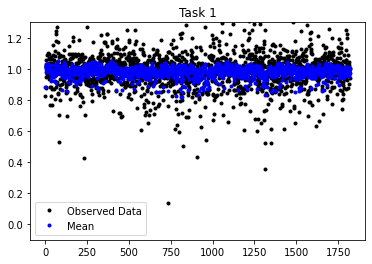

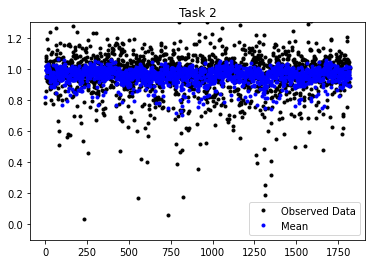

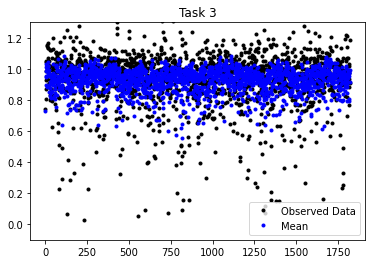

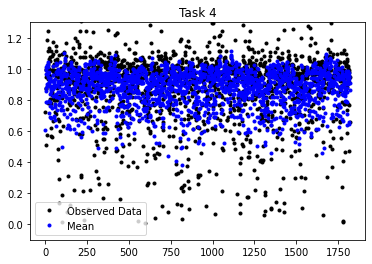

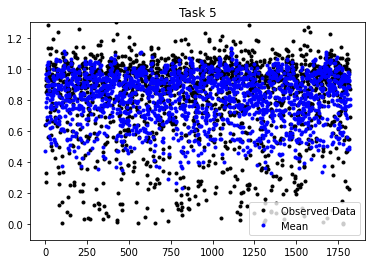

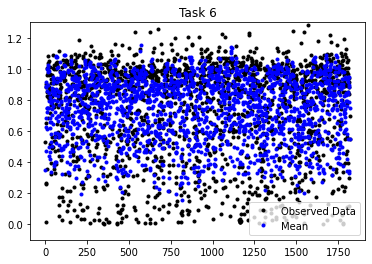

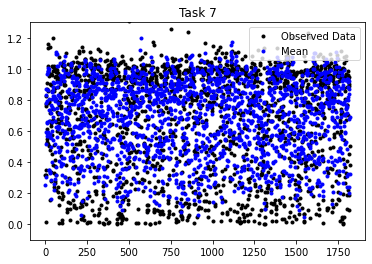

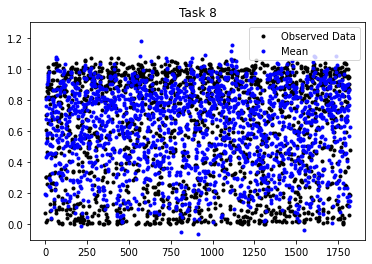

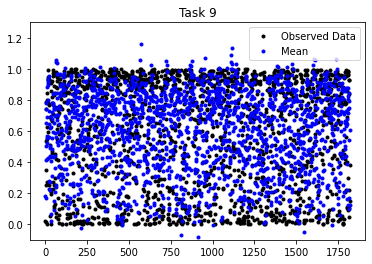

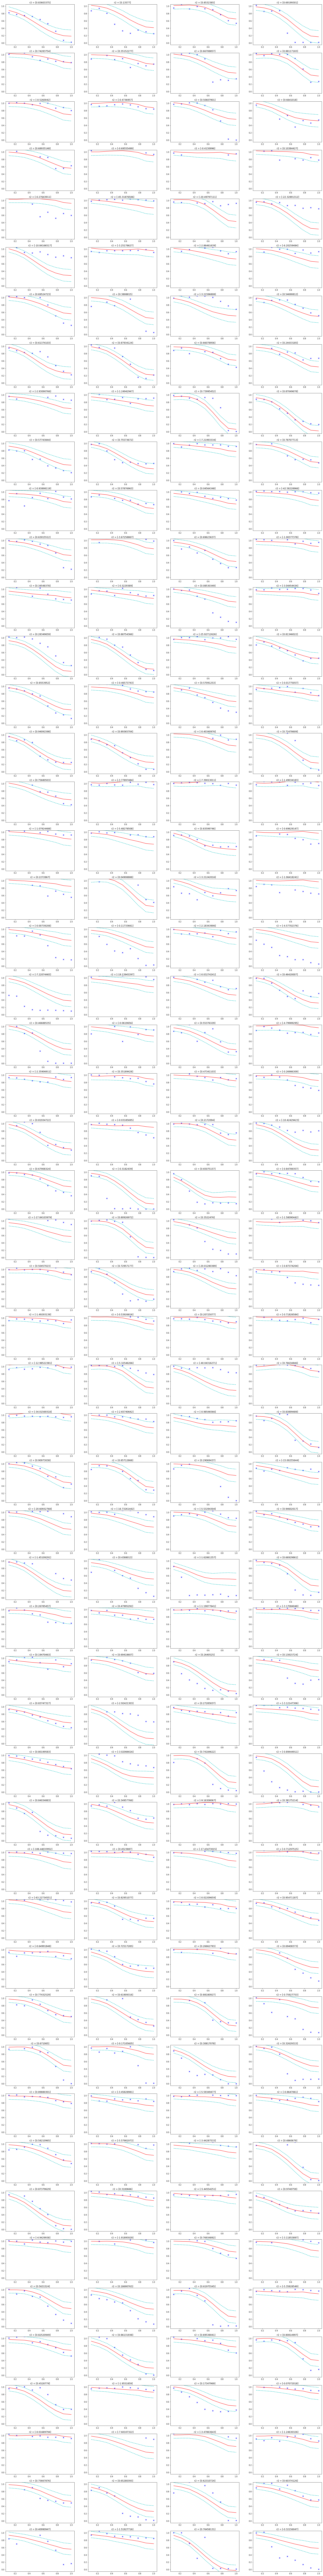

In [112]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import gc

from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import os

import scipy as sp

#_FOLDER = "/data/ac1jjgg/Data_Marina/results_with_NonAffecting_Drugs/"  #HPC folder
_FOLDER = "/home/juanjo/Work_Postdoc/my_codes_postdoc/DrugProfiles-master/results_with_NonAffecting_Drugs/"

### Coding Part

with open(_FOLDER + "drug_ids_50.txt", 'r') as f:
    drug_ids_50 = [np.int32(line.rstrip('\n')) for line in f]

with open(_FOLDER + "X_features_cancer_cell_lines.txt", 'r') as f:
    X_cancer_cell_lines = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER + "X_PubChem_properties.txt", 'r') as f:
    X_PubChem_properties = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER + "X_features_Targets.txt", 'r') as f:
    X_targets = [line.rstrip('\n') for line in f]
# *****************************************

with open(_FOLDER + "X_features_Target_Pathway.txt", 'r') as f:
    X_target_pathway = [line.rstrip('\n') for line in f]
# *****************************************
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


GDSC_Info = pd.read_csv(_FOLDER+"Cell_list_GDSC.csv")  #Contains info of cancer types for both GDSC1 and GDSC2
df_GDSC1 = GDSC_Info[GDSC_Info["Dataset"]=="GDSC1"]
df_OneCancer = df_GDSC1[df_GDSC1["Tissue"]=="lung"].reset_index()
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
all_columns = X_cancer_cell_lines + X_PubChem_properties + X_targets + X_target_pathway + ["MAX_CONC"]

train_df = pd.read_csv(_FOLDER + "train08_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(
    ["Unnamed: 0", "Unnamed: 0.1"], axis=1)
test_df = pd.read_csv(_FOLDER + "test02_merged_fitted_sigmoid4_123_with_drugs_properties_min10.csv").drop(
    ["Unnamed: 0", "Unnamed: 0.1"], axis=1)

train_df_50 = train_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()
test_df_50 = test_df.set_index("DRUG_ID").loc[drug_ids_50, :].copy()

datasets = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"]

X_feat_dict = {"Dataset 1": X_cancer_cell_lines,
               "Dataset 2": ["MAX_CONC"] + X_targets + X_target_pathway + X_cancer_cell_lines,
               "Dataset 3": ["MAX_CONC"] + X_PubChem_properties + X_cancer_cell_lines,
               "Dataset 4": ["MAX_CONC"] + X_PubChem_properties + X_targets + X_target_pathway + X_cancer_cell_lines}

### Coefficient_1

train_drug = train_df_50.copy()
test_drug = test_df_50.copy()

data_set = "Dataset 4"
X_columns = X_feat_dict[data_set]
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
df_train_drug_new = train_drug[train_drug["COSMIC_ID"] == df_OneCancer["COSMICID"][0]]
for i in range(1, df_OneCancer.shape[0]):
    df_aux = train_drug[train_drug["COSMIC_ID"] == df_OneCancer["COSMICID"][i]]
    df_train_drug_new = pd.concat([df_train_drug_new, df_aux])

df_test_drug_new = test_drug[test_drug["COSMIC_ID"] == df_OneCancer["COSMICID"][0]]
for i in range(1, df_OneCancer.shape[0]):
    df_aux = test_drug[test_drug["COSMIC_ID"] == df_OneCancer["COSMICID"][i]]
    df_test_drug_new = pd.concat([df_test_drug_new, df_aux])

df_train_drug_new = df_train_drug_new.reset_index()
df_test_drug_new = df_test_drug_new.reset_index()
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
scaler = MinMaxScaler().fit(df_train_drug_new[X_columns])
Xtrain_drug = scaler.transform(df_train_drug_new[X_columns])
Xtest_drug = scaler.transform(df_test_drug_new[X_columns])

y_train_drug = np.clip(df_train_drug_new["norm_cells_"+str(1)].values[:,None],1.0e-9,np.inf)
y_test_drug =  np.clip(df_test_drug_new["norm_cells_"+str(1)].values[:,None],1.0e-9,np.inf)
print(y_train_drug.shape)
for i in range(2,10):
    y_train_drug = np.concatenate((y_train_drug,np.clip(df_train_drug_new["norm_cells_"+str(i)].values[:,None],1.0e-9,np.inf)),1)
    y_test_drug = np.concatenate((y_test_drug,np.clip(df_test_drug_new["norm_cells_"+str(i)].values[:,None],1.0e-9,np.inf)),1)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
params_4_sig_train = df_train_drug_new["param_"+str(1)].values[:,None]
params_4_sig_test = df_test_drug_new["param_"+str(1)].values[:,None]
for i in range(2,5):
    params_4_sig_train = np.concatenate((params_4_sig_train,df_train_drug_new["param_"+str(i)].values[:,None]),1)
    params_4_sig_test = np.concatenate((params_4_sig_test,df_test_drug_new["param_"+str(i)].values[:,None]),1)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

### Training data for the GP ###
output_dim = y_train_drug.shape[1]
N_per_out = Xtrain_drug.shape[0]
#aux_label_outputs = np.tile(np.arange(0,output_dim),(N_per_out,1)).T.reshape(-1) #Create labels for X
Xall = Xtrain_drug.copy()  #Here replicate (10,1) due to having ten outputs.
#Xtrain = np.concatenate((Xtrain,aux_label_outputs[:,None]),axis=1)
Yall = y_train_drug.copy()

### Testing data for the GP ###
N_per_out_test = Xtest_drug.shape[0]
#aux_label_outputs_test = np.tile(np.arange(0,output_dim),(N_per_out_test,1)).T.reshape(-1) #Create labels for X
Xtest = Xtest_drug.copy()  #Here replicate (10,1) due to having ten outputs.
#Xtest= np.concatenate((Xtest,aux_label_outputs_test[:,None]),axis=1)
Ytest = y_test_drug.copy()
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
def sigmoid_4_param(x, x0, L, k, d):
    """ Comparing with Dennis Wang's sigmoid:
    x0 -  p - position, correlation with IC50 or EC50
    L = 1 in Dennis Wang's sigmoid, protect from devision by zero if x is too small
    k = -1/s (s -shape parameter)
    d - determines the vertical position of the sigmoid - shift on y axis - better fitting then Dennis Wang's sigmoid

    """
    return ( 1/ (L + np.exp(-k*(x-x0))) + d)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
x_lin = np.linspace(0,1,1000)
x_lin_tile = np.tile(x_lin,(params_4_sig_train.shape[0],1))
#(x_lin,params_4_sig_train.shape[0],1).shape
Ydose_res = []
IC50_all = []
Ydose50_all = []
for i in range(params_4_sig_train.shape[0]):
    Ydose_res.append(sigmoid_4_param(x_lin_tile[i,:],*params_4_sig_train[i,:]))
    res1=(Ydose_res[i]<0.507)
    res2=(Ydose_res[i]>0.493)
    if (res1 & res2).sum()>0:
        Ydose50_all.append(Ydose_res[i][res1 & res2].mean())
        IC50_all.append(x_lin[res1 & res2].mean())
    else:
        Ydose50_all.append(x_lin[-1])
        IC50_all.append(x_lin[-1])

Ydose50_all = np.array(Ydose50_all)
IC50_all = np.array(IC50_all)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import getopt
import sys

warnings.filterwarnings("ignore")
#os.environ['PATH'] = os.environ['PATH'] + ':/usr/texbin'

class commandLine:
    def __init__(self):
        opts, args = getopt.getopt(sys.argv[1:], 'l:b:m:i:w:s:r:d:p:f:')
        # opts = dict(opts)
        # print(opts)
        self.minibatch = 100   # mini-batch size for stochastic inference
        self.inducing = 500    #number of inducing points
        self.N_iter_epoch = 0    #number of iterations
        self.num_latentGPs = 9  #number of latent GPs
        #self.which_model = 'VIK'   #LMC  #CPM
        self.which_seed = 1010    #change seed to initialise the hyper-parameters
        self.weight = 0.05
        self.scale = 3.0
        self.split_dim = 40
        self.Nfold = 3
        self.bash = "None"

        for op, arg in opts:
            # print(op,arg)
            if op == '-l':
                self.num_latentGPs = arg
            if op == '-b':
                self.minibatch = arg
            if op == '-m':
                self.inducing = arg
            if op == '-i':
                self.N_iter_epoch = arg
            if op == '-r':  # (r)and seed
                self.which_seed = arg
            if op == '-w':  # (r)and seed
                self.weight = arg
            if op == '-s':  # (r)and seed
                self.scale = arg
            if op == '-p':  # (p)ython bash
                self.bash = arg
            if op == '-d':  # split of the additive kernel
                self.split_dim = arg
            if op == '-f':  # Nfold to select for Cross-Validation
                self.Nfold = arg

""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
config = commandLine()
""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"Create a K-fold for cross-validation"
from sklearn.model_selection import KFold, cross_val_score
Xind = np.arange(N_per_out)
k_fold = KFold(n_splits=5,shuffle=True,random_state=0)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
Nfold = 0
select_fold = 3#int(config.Nfold)
for train_id, val_id in k_fold.split(Xind):
    if Nfold == select_fold:
        print(f"Using Fold {Nfold}")
        Xval = Xall[val_id, :].copy()
        Xtrain = Xall[train_id, :].copy()
        Yval = Yall[val_id, :].copy()
        Ytrain = Yall[train_id, :].copy()
        break
    Nfold +=1

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"SEED"
torch.manual_seed(0)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
import os
#os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
minibatch = int(config.minibatch)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
train_x = torch.from_numpy(Xtrain.astype(np.float32))
train_y = torch.from_numpy(Ytrain.astype(np.float32))
val_x = torch.from_numpy(Xval.astype(np.float32))
val_y = torch.from_numpy(Yval.astype(np.float32))

from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=minibatch, shuffle=True)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
num_latents = int(config.num_latentGPs) #9
num_tasks = Ytrain.shape[1]
split_dim = int(config.split_dim)
num_inducing = int(config.inducing)

myseed = int(config.which_seed)

np.random.seed(myseed)
minis = Xall.min(0)
maxis = Xall.max(0)
Dim = Xall.shape[1]
Z = np.linspace(minis[0], maxis[0], num_inducing).reshape(1, -1)
for i in range(Dim - 1):
    Zaux = np.linspace(minis[i + 1], maxis[i + 1], num_inducing)
    Z = np.concatenate((Z, Zaux[np.random.permutation(num_inducing)].reshape(1, -1)), axis=0)
Z = 1.0 * Z.T

class MultitaskGPModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        # Let's use a different set of inducing points for each latent function
        #inducing_points = torch.rand(num_latents, num_inducing, Dim)
        inducing_points = torch.tensor(np.repeat(Z[None,:,:],num_latents,axis=0).astype(np.float32))

        # We have to mark the CholeskyVariationalDistribution as batch
        # so that we learn a variational distribution for each task
        variational_distribution = gpytorch.variational.CholeskyVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents])
        )

        # We have to wrap the VariationalStrategy in a LMCVariationalStrategy
        # so that the output will be a MultitaskMultivariateNormal rather than a batch output
        variational_strategy = gpytorch.variational.LMCVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=True
            ),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1
        )

        super().__init__(variational_strategy)

        # The mean and covariance modules should be marked as batch
        # so we learn a different set of hyperparameters
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([num_latents]))

        size_dims = (Dim) // split_dim

        # mykern = gpytorch.kernels.RBFKernel(active_dims=torch.tensor(list(np.arange(0,size_dims))),batch_shape=torch.Size([num_latents]))
        mykern = gpytorch.kernels.LinearKernel(active_dims=torch.tensor(list(np.arange(0, size_dims))),
                                               batch_shape=torch.Size([num_latents]),
                                               ard_num_dims=size_dims) + gpytorch.kernels.MaternKernel(nu=0.5,
                                                                                                       active_dims=torch.tensor(
                                                                                                           list(
                                                                                                               np.arange(
                                                                                                                   0,
                                                                                                                   size_dims))),
                                                                                                       batch_shape=torch.Size(
                                                                                                           [
                                                                                                               num_latents]),
                                                                                                       ard_num_dims=size_dims)
        for i in range(1, split_dim):
            if i != (split_dim - 1):
                mykern = mykern + gpytorch.kernels.LinearKernel(
                    active_dims=torch.tensor(list(np.arange(size_dims * i, size_dims * i + size_dims))),
                    batch_shape=torch.Size([num_latents]), ard_num_dims=size_dims) + gpytorch.kernels.MaternKernel(
                    nu=0.5, active_dims=torch.tensor(list(np.arange(size_dims * i, size_dims * i + size_dims))),
                    batch_shape=torch.Size([num_latents]), ard_num_dims=size_dims)
                # print(torch.tensor(list(np.arange(size_dims*i,size_dims*i+size_dims))))
            else:
                last_dims = Dim - size_dims * i
                mykern = mykern + gpytorch.kernels.LinearKernel(
                    active_dims=torch.tensor(list(np.arange(size_dims * i, Dim))),
                    batch_shape=torch.Size([num_latents]), ard_num_dims=last_dims) + gpytorch.kernels.MaternKernel(
                    nu=0.5, active_dims=torch.tensor(list(np.arange(size_dims * i, Dim))),
                    batch_shape=torch.Size([num_latents]), ard_num_dims=last_dims)
                # print(torch.tensor(list(np.arange(size_dims*i,Dim))))

        self.covar_module = gpytorch.kernels.ScaleKernel(mykern,
                                                         batch_shape=torch.Size([num_latents])
                                                         )

    def forward(self, x):
        # The forward function should be written as if we were dealing with each output
        # dimension in batch
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
model = MultitaskGPModel()
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
np.random.seed(myseed)

#myweights = 0.2 * np.ones((num_latents,num_tasks))
myweights = float(config.weight) * np.random.rand(num_latents,num_tasks)
model.variational_strategy.lmc_coefficients = torch.nn.Parameter(torch.tensor(myweights.astype(np.float32)))

for i in range(split_dim):
    d1,d2,d3 = model.covar_module.base_kernel.kernels[2 * i + 1].lengthscale.size()
    mylengthscale = float(config.scale) * np.sqrt(Dim) * np.random.rand(d1,d2,d3)
    #mylengthscale = 0.2*np.ones((d1,d2,d3))
    model.covar_module.base_kernel.kernels[2*i+1].lengthscale = torch.tensor(mylengthscale)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks,
                                                              noise_constraint=gpytorch.constraints.Interval(1.0e-5,
                                                                                                             1.0e-3))
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
m_trained = "48"
print("loading model ",m_trained)
state_dict = torch.load('m_'+m_trained+'.pth')
model.load_state_dict(state_dict)
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""

# # this is for running the notebook in our testing framework
# import os
# #smoke_test = ('CI' in os.environ)
# #num_epochs = 1 if smoke_test else 2
# num_epochs = int(config.N_iter_epoch)
#
# model.train()
# likelihood.train()
#
# optimizer = torch.optim.Adam([
#     {'params': model.parameters()},
#     {'params': likelihood.parameters()},
# ], lr=0.005)
#
# # Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
# mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))
# """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
#
# Ntrain,_ = Ytrain.shape
# show_each = Ntrain//train_loader.batch_size
# refine_lr = [0.005,0.001,0.0005,0.0001]
# refine_num_epochs = [num_epochs,int(num_epochs*0.5),int(num_epochs*0.2),int(num_epochs*0.2)]
# for Nrefine in range(len(refine_lr)):
#     print(f"\nRefine Learning Rate {Nrefine}; lr={refine_lr[Nrefine]}")
#     for g in optimizer.param_groups:
#         g['lr'] = refine_lr[Nrefine]
#
#     for i in range(refine_num_epochs[Nrefine]):
#         print(f"Epoch {i}")
#         # Within each iteration, we will go over each minibatch of data
#         #minibatch_iter = tqdm(train_loader, desc = 'Minibatch')
#         for j, (x_batch, y_batch) in enumerate(train_loader):
#             optimizer.zero_grad()
#             output = model(x_batch)
#             loss = -mll(output, y_batch)
#             if j%(show_each//2)==0:
#                 print(f"Minbatch {j}, Loss {loss}")
#
#             loss.backward()
#             optimizer.step()
# """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# """""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# # Set into eval mode
# model.eval()
# likelihood.eval()

# Initialize plots
#fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(val_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
plt.close('all')
for task in range(num_tasks):
    # Plot training data as black stars
    plt.figure(task)
    plt.plot(val_y[:, task].detach().numpy(), 'k.')
    # Predictive mean as blue line
    plt.plot(mean[:, task].numpy(), '.b')
    # Shade in confidence
    #ax.fill_between(test_x.numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    plt.ylim([-0.1, 1.3])
    plt.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.title(f'Task {task + 1}')

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
r2_scr = r2_score(val_y.T, mean.T, multioutput='raw_values')[:,None]
myMSE = np.mean((val_y.numpy()-mean.numpy())**2,1)
myEmax_Err = np.abs(np.mean(val_y.numpy()[:,-2:],1)-np.mean(mean.numpy()[:,-2:],1))
myAUC_Err = np.zeros(val_y.numpy().shape[0])
from sklearn import metrics
for i in range(val_y.numpy().shape[0]):
    AUC_val = metrics.auc(np.linspace(0.11,1,9),val_y.numpy()[i,:])
    AUC_pred = metrics.auc(np.linspace(0.11, 1, 9), mean.numpy()[i, :])
    myAUC_Err[i] = np.abs(AUC_val-AUC_pred)

print("Median R2: ",np.median(r2_scr))
print("Mean R2: ",np.mean(r2_scr))
print("Median MSE: ",np.median(myMSE))
print("Mean MSE: ",np.mean(myMSE))
print("Median Emax_abs:",np.median(myEmax_Err))
print("Mean Emax_abs:",np.mean(myEmax_Err))
print("Median AUC_abs:",np.median(myAUC_Err))
print("Mean AUC_abs:",np.mean(myAUC_Err))
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
from scipy.interpolate import interp1d
x_dose = np.linspace(0.111111,1.0,9)
x_dose_new = np.linspace(0.111111,1.0,1000)
Ydose50_val = []
IC50_val = []
for i in range(val_y.numpy().shape[0]):
    y_resp = mean.numpy()[i,:].copy()
    f = interp1d(x_dose, y_resp)
    f2 = interp1d(x_dose, y_resp, kind='quadratic')

    y_resp_interp = f2(x_dose_new)
    res1 = y_resp_interp<0.507
    res2 = y_resp_interp>0.493
    if (res1 & res2).sum()>0:
        Ydose50_val.append( y_resp_interp[res1 & res2].mean())
        IC50_val.append( x_dose_new[res1 & res2].mean())
    else:
        Ydose50_val.append( x_dose_new[-1])
        IC50_val.append( x_dose_new[-1])

Ydose50_val = np.array(Ydose50_val)
IC50_val = np.array(IC50_val)

print("IC50 MSE:",np.mean((IC50_all[val_id]-IC50_val)**2))

IC50_Y_Val = IC50_all[val_id]
pos_NonAffect = IC50_Y_Val==1.0
pos_Affect = pos_NonAffect==False
print("IC50 MSE val NonAffect:",np.mean((IC50_Y_Val[pos_NonAffect]-IC50_val[pos_NonAffect])**2))
print("IC50 MSE val Affect:",np.mean((IC50_Y_Val[pos_Affect]-IC50_val[pos_Affect])**2))

# import matplotlib.pyplot as plt
# plt.figure(12)
# plt.plot(x_dose, y_resp, 'o', x_dose_new, f(x_dose_new), '-', x_dose_new, y_resp_interp, '--')
# plt.legend(['data', 'linear', 'cubic'], loc='best')
# plt.plot(x_dose,val_y[posy_check,:],'xr')
# plt.plot(IC50,Ydose50,'xb')
# plt.show()
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
# f= open("Metrics.txt","a+")
# f.write("bash"+str(config.bash)+f" R2Med={np.median(r2_scr):0.3f} R2Mean={r2_scr.mean():0.3f} MSEMed={np.median(myMSE):0.4f} MSEMean={myMSE.mean():0.4f} EmaxMed={np.median(myEmax_Err):0.4f} EmaxMean={myEmax_Err.mean():0.4f} AUCMed={np.median(myAUC_Err):0.4f} AUCMean={myAUC_Err.mean():0.4f}\n")
# f.close()
#
# f= open("Summary_Metric.txt","a+")
# summary_metric_med = (-1.0*np.median(r2_scr)+np.median(myMSE)+np.median(myEmax_Err)+np.median(myAUC_Err))/4.0
# summary_metric_mean = (-1.0*np.mean(r2_scr)+np.mean(myMSE)+np.mean(myEmax_Err)+np.mean(myAUC_Err))/4.0
# f.write("bash"+str(config.bash)+f" Summary_Med={summary_metric_med:0.5f} Summary_Mean={summary_metric_mean:0.5f}\n")
# f.close()
#
# print("\nMedian Summary:", summary_metric_med)
# print("\nMean Summary:", summary_metric_mean)
#
# #final_path = '/data/ac1jjgg/Data_Marina/GPyTorch_results/LungCancer_GPAdditiveCorrectRealY/'
# final_path ='model_LungCancer/'
# if not os.path.exists(final_path):
#     os.makedirs(final_path)
#
# #torch.save(model.state_dict(), final_path+'m_'+str(config.bash)+'.pth')

Nrow = 107//2
Ncolumn = 4
fig, axs = plt.subplots(Nrow, Ncolumn, figsize=(30,50*(Nrow//10)))

#test_y, mean
posy = 0
for i in range(Nrow):
    for j in range(Ncolumn):
        #posy = np.random.randint(val_y.shape[0])
        axs[i, j].plot(np.linspace(0.11,1,9), val_y[posy,:],'xb')
        axs[i, j].plot(np.linspace(0.11,1,9), val_y[posy,:],'.b')
        axs[i, j].plot(np.linspace(0.11,1,9), mean[posy,:],'-r')
        axs[i, j].plot(np.linspace(0.11,1,9), lower[posy,:],'--c')
        axs[i, j].plot(np.linspace(0.11,1,9), upper[posy,:],'--c')
        axs[i, j].set_title("r2 = "+str(r2_scr[posy,:]))
        axs[i, j].set_ylim([-0.05, 1.05])
        posy = posy + 1
        if posy == 855:
            break

print(posy)
#fig.savefig('validation_m_130_0-212.pdf',dpi=300)

In [113]:
model.variational_strategy.lmc_coefficients

Parameter containing:
tensor([[-1.3383e-03,  6.3283e-03,  1.7510e-02,  2.9699e-02,  4.0319e-02,
          4.3271e-02,  3.9286e-02,  3.1168e-02,  2.9715e-02],
        [-5.1759e-04, -1.5702e-03, -1.9520e-03, -3.2809e-04,  4.2115e-03,
          1.0710e-02,  2.2464e-02,  3.1287e-02,  3.2000e-02],
        [-7.7583e-04, -1.7239e-03, -1.2912e-03,  2.4442e-03,  6.9112e-03,
          1.1591e-02,  1.2693e-02,  1.2368e-02,  1.2105e-02],
        [-3.9963e-04,  1.0583e-04,  1.1158e-03,  3.0781e-03,  4.7299e-03,
          4.9981e-03,  7.0687e-03,  8.5178e-03,  8.6645e-03],
        [ 6.4582e-04, -3.7255e-03, -6.4530e-03, -6.0520e-03,  3.4377e-04,
          1.6169e-02,  3.3009e-02,  4.4131e-02,  4.4752e-02],
        [ 2.1320e-03,  1.0063e-02,  1.7231e-02,  2.1134e-02,  2.0190e-02,
          1.4991e-02,  1.2576e-02,  1.1390e-02,  1.1288e-02],
        [ 4.3635e-02,  3.9849e-02,  3.5242e-02,  2.9787e-02,  2.4917e-02,
          2.0995e-02,  1.7629e-02,  1.5046e-02,  1.4338e-02],
        [-4.2414e-04,  5.7

In [114]:
model

MultitaskGPModel(
  (variational_strategy): LMCVariationalStrategy(
    (base_variational_strategy): VariationalStrategy(
      (_variational_distribution): CholeskyVariationalDistribution()
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): AdditiveKernel(
      (kernels): ModuleList(
        (0): LinearKernel(
          (raw_variance_constraint): Positive()
        )
        (1): MaternKernel(
          (raw_lengthscale_constraint): Positive()
          (distance_module): Distance()
        )
        (2): LinearKernel(
          (raw_variance_constraint): Positive()
        )
        (3): MaternKernel(
          (raw_lengthscale_constraint): Positive()
          (distance_module): Distance()
        )
        (4): LinearKernel(
          (raw_variance_constraint): Positive()
        )
        (5): MaternKernel(
          (raw_lengthscale_constraint): Positive()
          (distance_module): Distance()
        )
        (6): LinearKernel(
      

In [115]:
model.covar_module.base_kernel.kernels[1].lengthscale.shape

torch.Size([9, 1, 33])

In [116]:
ARD_lscales = model.covar_module.base_kernel.kernels[1].lengthscale.detach().numpy()
ARD_lscales = ARD_lscales[:,0,:].copy()

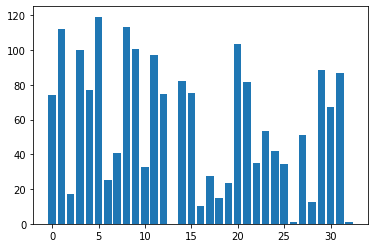

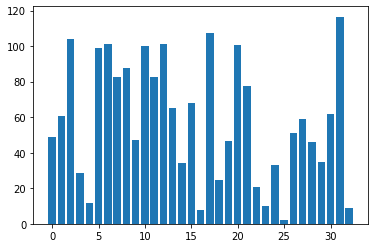

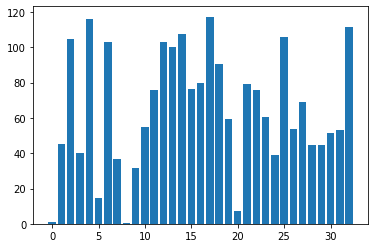

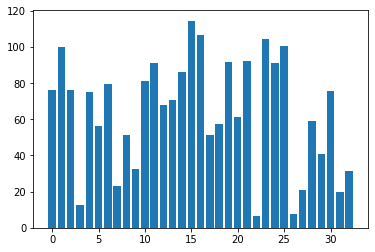

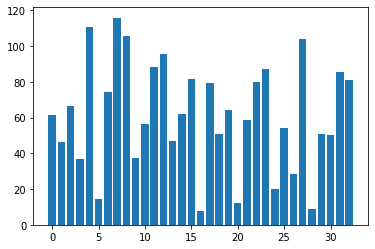

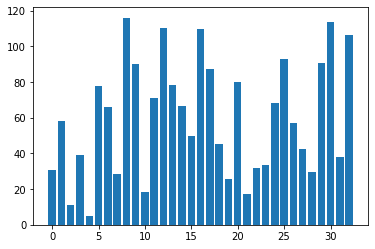

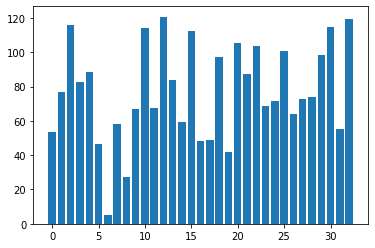

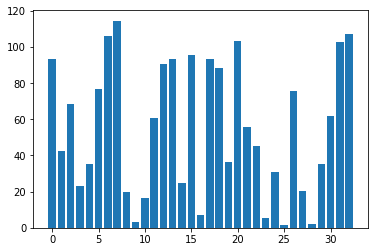

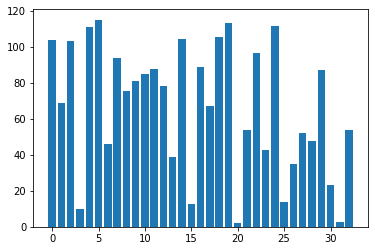

In [117]:
NGPlatent, ARD_dim = ARD_lscales.shape
for i in range(NGPlatent):
    plt.figure(i)
    plt.bar(np.arange(0,ARD_dim),ARD_lscales[i,:])

In [118]:
#This lin_coeffs is size num_latents_GPs x num_tasks
lin_coeffs = model.variational_strategy.lmc_coefficients.detach().numpy()

In [119]:
#lin_coeffs[:,0].shape
#ARD_lscales.shape
#These lines below is to treat them inversely, I mean, since a small lenghtscalse means more important
#but a small linear coeff weight mean not that important, I aim to use the inverse lenghtscale to have similar direction
#of importance withe the weights, I mean a big weight and a large lengthscale are more important.
ARD_lscales_inv = 1.0/ARD_lscales 
ARD_W_x_GPs = np.abs(lin_coeffs[:,0][:,None])*ARD_lscales_inv   

<BarContainer object of 33 artists>

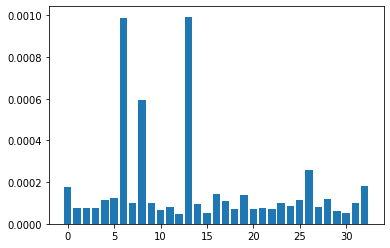

In [120]:
#ARD_W_x_GPs
Mean_ARD = np.zeros_like( ARD_W_x_GPs[0,:])
for i in range(NGPlatent):
    Mean_ARD = Mean_ARD + ARD_W_x_GPs[i,:]
Mean_ARD = Mean_ARD/float(NGPlatent)    
plt.bar(np.arange(0,ARD_dim),Mean_ARD)    

In [121]:
#out_task = 8 
ARD_All_Outputs = []
for out_task in range(0,9):
    
    for i in range(0,split_dim): 
        ARD_lscales = model.covar_module.base_kernel.kernels[i*2+1].lengthscale.detach().numpy()
        ARD_lscales = ARD_lscales[:,0,:].copy()
        NGPlatent, ARD_dim = ARD_lscales.shape
        ARD_lscales_inv = 1.0/ARD_lscales 
        ARD_W_x_GPs = np.abs(lin_coeffs[:,out_task][:,None])*ARD_lscales_inv
        Mean_ARD = np.zeros_like( ARD_W_x_GPs[0,:])
        for q in range(NGPlatent):
            Mean_ARD = Mean_ARD + ARD_W_x_GPs[q,:]
        Mean_ARD = Mean_ARD/float(NGPlatent)
        if i ==0:
            All_Means_ARD = Mean_ARD.copy()
        else:
            All_Means_ARD = np.concatenate((All_Means_ARD,Mean_ARD.copy()))
        #plt.figure(i)
        #plt.bar(np.arange(0,ARD_dim),Mean_ARD)
    ARD_All_Outputs.append(All_Means_ARD)

In [122]:
ARD_All_Outputs

[array([1.7433733e-04, 7.4371390e-05, 7.5461518e-05, ..., 6.8032379e-05,
        7.9234007e-05, 1.2480060e-04], dtype=float32),
 array([0.00029915, 0.00010406, 0.00019252, ..., 0.00013655, 0.00011818,
        0.0002285 ], dtype=float32),
 array([0.0003049 , 0.00013743, 0.00034307, ..., 0.00020742, 0.00016836,
        0.00036421], dtype=float32),
 array([0.00043571, 0.00016131, 0.00046446, ..., 0.00023136, 0.0002093 ,
        0.0004307 ], dtype=float32),
 array([0.00085118, 0.00017803, 0.00052659, ..., 0.00019322, 0.00024456,
        0.00052177], dtype=float32),
 array([0.00130292, 0.0002349 , 0.00053359, ..., 0.00039393, 0.00032308,
        0.00085872], dtype=float32),
 array([0.00144485, 0.00029438, 0.00052896, ..., 0.00062197, 0.00041681,
        0.00125298], dtype=float32),
 array([0.00143647, 0.000326  , 0.00049301, ..., 0.00076776, 0.00047066,
        0.00148652], dtype=float32),
 array([0.00141123, 0.00032528, 0.0004834 , ..., 0.0007742 , 0.0004711 ,
        0.00149403], dtype=fl

In [123]:
ARD_Mean_OverAll = np.mean(ARD_All_Outputs,0)
ARD_Mean_OverAll.shape

(1352,)

In [124]:
ARD_Mean_OverAll_norm = ARD_Mean_OverAll/np.max(ARD_Mean_OverAll)
np.max(ARD_Mean_OverAll_norm)

1.0

(0.0, 1.02)

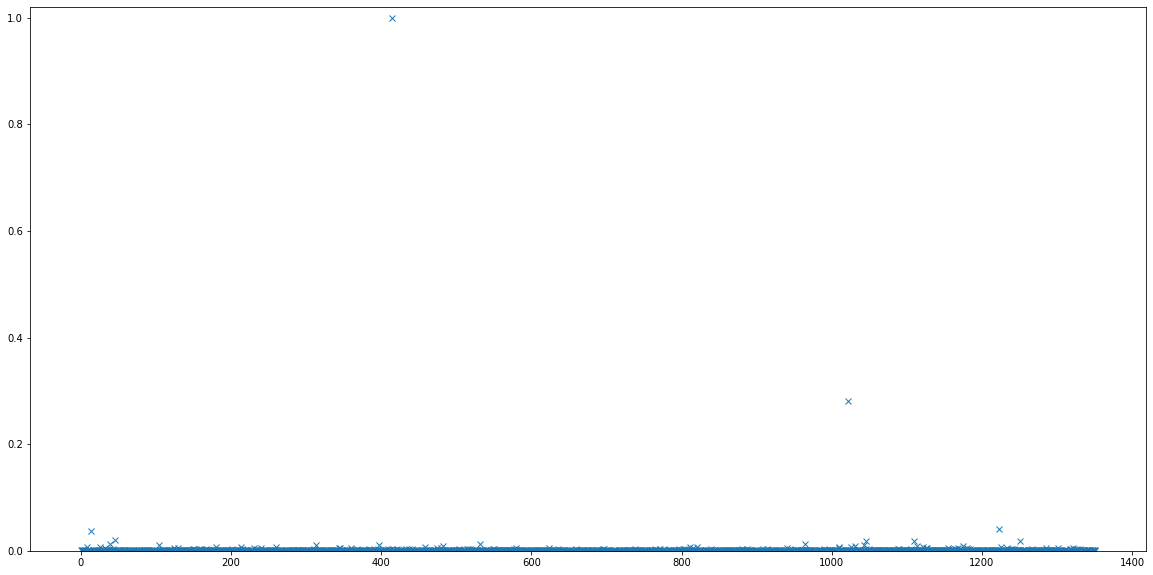

In [125]:
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,1352),ARD_Mean_OverAll_norm,'x')
plt.ylim([0,1.02])
#plt.bar(np.arange(0,1352),ARD_Mean_OverAll)

In [126]:
#ARD_Mean_OverAll_norm
df_feature_relevance = pd.DataFrame(ARD_Mean_OverAll_norm[None,:], columns=X_columns)

In [127]:
#df[df['col1'] >= 1]
np.where(df_feature_relevance>=0.95)[1][0]
df_feature_relevance

,MAX_CONC,molecular_weight,2bonds,3bonds,xlogp,formal_charge,surface_area,complexity,h_bond_donor_count,h_bond_acceptor_count,...,chr9:104248247-104249501(C9orf125)_HypMET,"chr9:115875199-115875738(C9orf109, C9orf110)_HypMET",chr9:123555399-123555899(FBXW2)_HypMET,chr9:140310894-140312457(EXD3)_HypMET,chr9:21974578-21975306(CDKN2A)_HypMET,chr9:35756948-35757339(MSMP)_HypMET,chr9:35791584-35791924(NPR2)_HypMET,chr9:4984543-4985630(JAK2)_HypMET,chr9:86571047-86572027(C9orf64)_HypMET,chr9:98783216-98784364(NCRNA00092)_HypMET
0,0.001677,0.000402,0.000797,0.000771,0.001099,0.000656,0.001616,0.000523,0.007564,0.000753,...,0.002287,0.000658,0.001352,0.000549,0.000995,0.00136,0.001726,0.000743,0.000547,0.00148


In [128]:
#df_feature_relevance>0.9
max_val_pos = np.where(df_feature_relevance>=0.95)[1][0]
print(df_feature_relevance.columns[max_val_pos])
df_feature_relevance.iloc[0,max_val_pos]

HNF1A_mut


1.0

In [129]:
df_feature_relevance.to_csv('df_feature_relevance.csv')  